# Оптимизация ценовой стратегии на маркетплейсе Ozon: анализ конкурентной среды

## Импорт необходимых библиотек, источника данных и первичное ознакомление с содержимым

In [1]:
# !pip install matplotlib
# !pip install seaborn
# !pip install plotly

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
# Загрузка данных
url = "https://docs.google.com/spreadsheets/d/1draL0IcMP94h3YChWrHMxfI0AG3gTBgNoXO3lqj0jKE/export?format=csv&gid=701508041"
df = pd.read_csv(url)

In [4]:
# Первичный осмотр данных
print(df.head())

   №           Offer ID           Категория                 Номенклатура  \
0  1         50810_ch_2           Подстолье                 Для 1600x800   
1  2  50885_z_chmatgl_5  Компьютерные столы           Подъемный 1600x800   
2  3         51392_bk_3          Столешница  прямоугольная 2000х900 (36)   
3  4       51396_t_ch_8     Обеденные столы                     1400х800   
4  5       51780_t_ch_6     Обеденные столы               1800х1000 (36)   

                Фактура Маркетинговая цена Мин. цена конкурентов  
0  Металлокаркас Черный              289,5                207,54  
1     Дуб золотой крафт            3072,15                     0  
2       Дуб белый крафт             416,73                     0  
3    Дуб табачный крафт             528,78                466,41  
4    Дуб табачный крафт             775,68                748,29  


In [5]:
# информация о содержании данных
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   №                      314 non-null    int64 
 1   Offer ID               314 non-null    object
 2   Категория              314 non-null    object
 3   Номенклатура           314 non-null    object
 4   Фактура                314 non-null    object
 5   Маркетинговая цена     314 non-null    object
 6   Мин. цена конкурентов  314 non-null    object
dtypes: int64(1), object(6)
memory usage: 17.3+ KB
None


In [6]:
# описательная статистика
print(df.describe())

                №
count  314.000000
mean   157.500000
std     90.788215
min      1.000000
25%     79.250000
50%    157.500000
75%    235.750000
max    314.000000


## Подготовка/ очистка данных для обработки и анализа

In [7]:
# 1. Функция для безопасного преобразования цен
def convert_price(price):
    """Безопасное преобразование строковых цен в float"""
    if pd.isna(price):
        return np.nan
    
    # Удаляем все нечисловые символы кроме точек и запятых
    cleaned = ''.join(c for c in str(price) 
                     if c.isdigit() or c in {',', '.'}).replace(',', '.')
    
    try:
        return float(cleaned) if cleaned else np.nan
    except ValueError:
        return np.nan

# Применяем ко всем ценовым колонкам
price_cols = ['Маркетинговая цена', 'Мин. цена конкурентов']
df[price_cols] = df[price_cols].applymap(convert_price)

C:\Users\Professional\AppData\Local\Temp\ipykernel_8116\3475702001.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[price_cols] = df[price_cols].applymap(convert_price)


In [8]:
# 2. Применяем функцию к ценовым колонкам
df['Маркетинговая цена'] = df['Маркетинговая цена'].apply(convert_price)
df['Мин. цена конкурентов'] = df['Мин. цена конкурентов'].apply(convert_price)



In [9]:
# 3. Заменяем нули и некорректные значения в ценах конкурентов на NaN
df['Мин. цена конкурентов'] = df['Мин. цена конкурентов'].replace(0, np.nan)


In [10]:
# 4. Проверяем результат
print("Уникальные значения в 'Маркетинговая цена':", df['Маркетинговая цена'].unique()[:10])
print("Уникальные значения в 'Мин. цена конкурентов':", df['Мин. цена конкурентов'].unique()[:10])
print("\nКоличество пропущенных значений:")
print(df[['Маркетинговая цена', 'Мин. цена конкурентов']].isna().sum())


Уникальные значения в 'Маркетинговая цена': [ 289.5  3072.15  416.73  528.78  775.68  382.71  526.83  381.15  910.35
  261.39]
Уникальные значения в 'Мин. цена конкурентов': [207.54    nan 466.41 748.29 345.63 343.68 584.61 634.14 292.35 316.14]

Количество пропущенных значений:
Маркетинговая цена         0
Мин. цена конкурентов    133
dtype: int64


In [11]:
# 5. Описательная статистика по ценам
print("\nОписательная статистика по ценам:")
print(df[['Маркетинговая цена', 'Мин. цена конкурентов']].describe().applymap(
    lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x))


Описательная статистика по ценам:
      Маркетинговая цена Мин. цена конкурентов
count             314.00                181.00
mean              608.30                464.41
std               438.10                266.86
min                87.36                 60.90
25%               347.99                266.97
50%               506.37                365.25
75%               753.68                612.66
max              3072.15               1403.37


C:\Users\Professional\AppData\Local\Temp\ipykernel_8116\682770646.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df[['Маркетинговая цена', 'Мин. цена конкурентов']].describe().applymap(


In [12]:
# 6. Анализ пропущенных данных
print("Анализ пропущенных цен конкурентов:")
print(f"Всего товаров: {len(df)}")
print(f"Товаров с данными о конкурентах: {len(df) - df['Мин. цена конкурентов'].isna().sum()}")
print(f"Товаров без данных о конкурентах: {df['Мин. цена конкурентов'].isna().sum()}")



Анализ пропущенных цен конкурентов:
Всего товаров: 314
Товаров с данными о конкурентах: 181
Товаров без данных о конкурентах: 133


### 1. Интерпретация данных о пропущенных значениях:
    42% товаров (133 из 314) не имеют данных о конкурентах. Это может означать:

        - Уникальные товары в вашем ассортименте
        - Пробелы в конкурентном анализе
        - Новинки рынка, которые еще не появились у конкурентов


###  2. Стратегические рекомендации:
    
    Для товаров с данными о конкурентах (181 товар):
    
            Товары дороже конкурентов на 50%+ (если такие есть):

        ** Провести ABC-анализ: действительно ли эти товары приносят прибыль?
        ** Рассмотреть bundle-предложения (связки с более популярными товарами)
        ** Усилить USP (уникальные торговые предложения) для этих позиций

            Товары дешевле конкурентов на 10%+:
            
        ** Проверить маржинальность - возможно необоснованное демпингование
        ** Проанализировать возможность постепенного повышения цены до рыночного уровня
        ** Конкурентоспособные товары (±10% к рынку):
        ** Оптимизировать рекламные бюджеты - эти товары могут быть "локомотивами"
        ** Мониторить динамику цен конкурентов

In [13]:
# Выявление информации по уникальным категориям

unique_products = df[df['Мин. цена конкурентов'].isna()]
print("Топ-5 категорий с уникальными товарами:")
print(unique_products['Категория'].value_counts().head(5))

Топ-5 категорий с уникальными товарами:
Категория
Компьютерные столы    47
Столешница            40
Обеденные столы       23
Подстолье             11
Сад                   10
Name: count, dtype: int64


## Визуализация пробелов конкурентной информации

C:\Users\Professional\AppData\Local\Temp\ipykernel_8116\1689751327.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=missing_data, palette=['green', 'red'])
C:\Users\Professional\AppData\Local\Temp\ipykernel_8116\1689751327.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Да', 'Нет'])


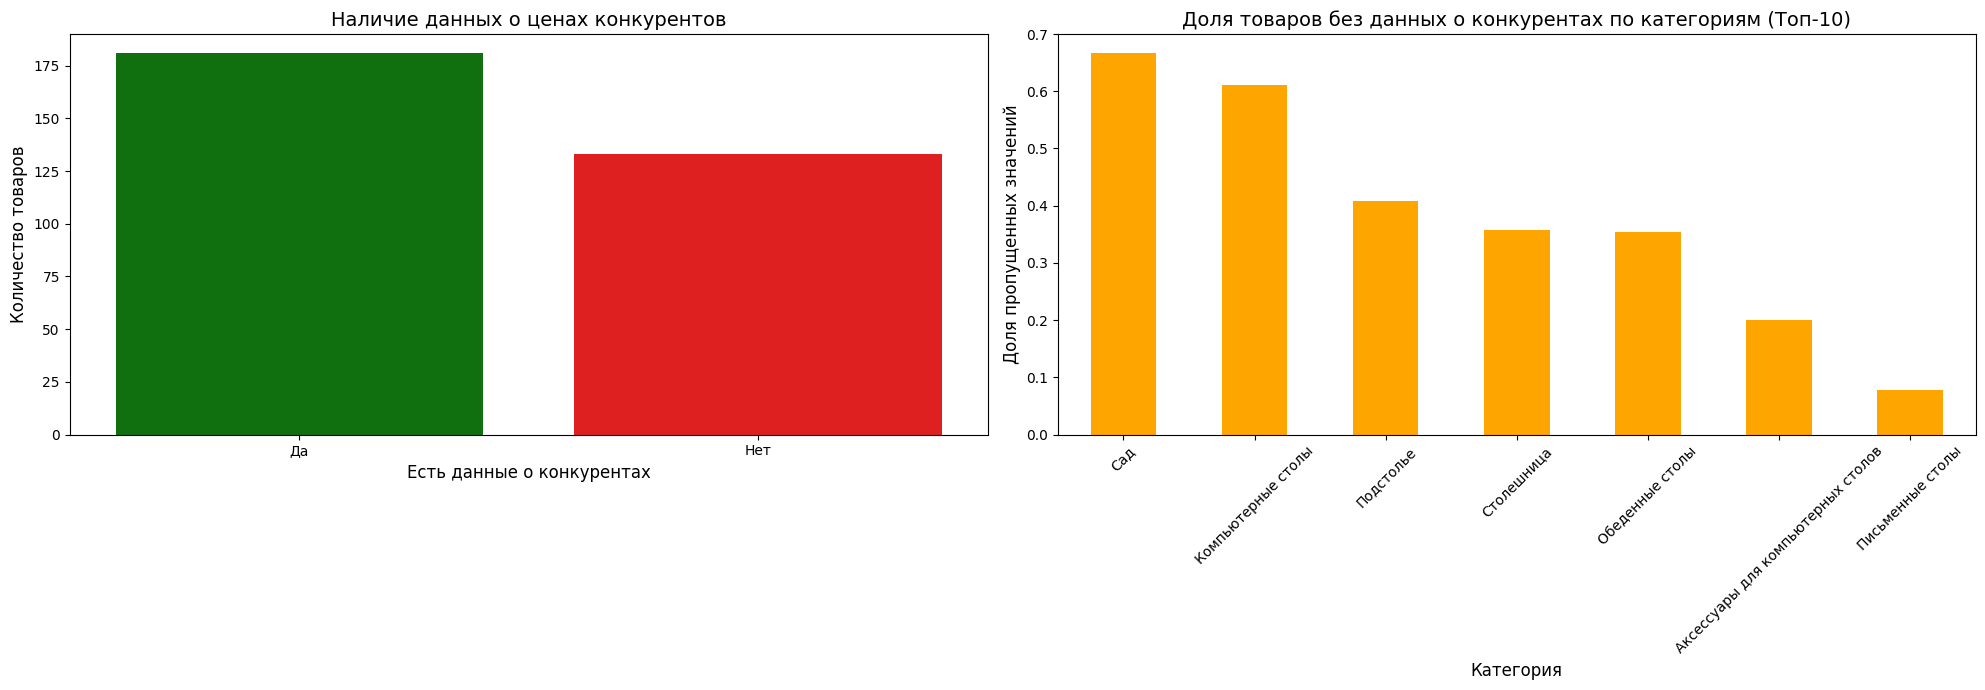

In [14]:

# Создаем фигуру с двумя подграфиками (1 строка, 2 столбца)
plt.figure(figsize=(20, 7))

# Первый график - распределение пропущенных значений
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, позиция 1
missing_data = df['Мин. цена конкурентов'].isna()
ax = sns.countplot(x=missing_data, palette=['green', 'red'])
plt.title('Наличие данных о ценах конкурентов', fontsize=14)
plt.xlabel('Есть данные о конкурентах', fontsize=12)
plt.ylabel('Количество товаров', fontsize=12)
ax.set_xticklabels(['Да', 'Нет'])

# Второй график - распределение по категориям
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, позиция 2
category_missing = df.groupby('Категория')['Мин. цена конкурентов'].apply(lambda x: x.isna().mean())
category_missing.sort_values(ascending=False).head(10).plot(kind='bar', color='orange')
plt.title('Доля товаров без данных о конкурентах по категориям (Топ-10)', fontsize=14)
plt.xlabel('Категория', fontsize=12)
plt.ylabel('Доля пропущенных значений', fontsize=12)
plt.xticks(rotation=45)

# Регулируем расстояние между графиками
plt.tight_layout()
plt.show()

### РЕКОМЕНДАЦИИ

    Немедленные меры:

        ** Сформировать список 10 самых дорогих уникальных товаров для проверки
        ** Выявить 5 категорий с наибольшим количеством "бесконкурентных" товаров

    Среднесрочные меры:

        ** Настроить систему мониторинга цен конкурентов
        ** Разработать методику ценообразования для уникальных товаров

    Долгосрочные меры:

        ** Внедрить динамическое ценообразование
        ** Разработать KPI по покрытию конкурентного анализа

## Плотность распределения цен и ценовые диапозоны категорий

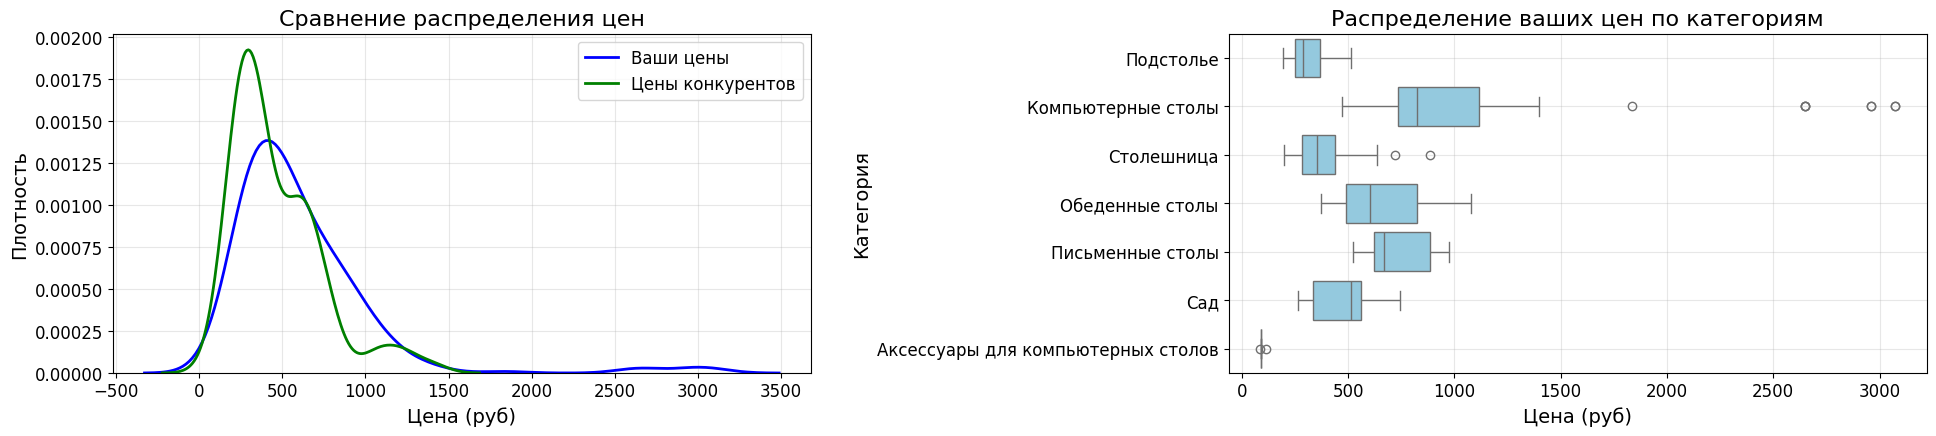

In [15]:
plt.figure(figsize=(20, 5))  # Увеличиваем размер фигуры для двух графиков

# График 1: Сравнение распределения цен (левый)
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, позиция 1
sns.kdeplot(df['Маркетинговая цена'], color='blue', label='Ваши цены', linewidth=2)
sns.kdeplot(df['Мин. цена конкурентов'].dropna(), color='green', label='Цены конкурентов', linewidth=2)
plt.title('Сравнение распределения цен', fontsize=16)
plt.xlabel('Цена (руб)', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# График 2: Boxplot цен по категориям (правый)
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, позиция 2
sns.boxplot(x='Маркетинговая цена', y='Категория', data=df, orient='h', color='skyblue')
plt.title('Распределение ваших цен по категориям', fontsize=16)
plt.xlabel('Цена (руб)', fontsize=14)
plt.ylabel('Категория', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout(pad=3.0)  # Добавляем больше пространства между графиками
plt.show()

## Сравнительный анализ цен по категориям

In [16]:
# Сравнительный анализ цен по категориям
import numpy as np
from IPython.display import display

# 1. Подготовка данных
analysis_table = df.groupby('Категория').agg({
    'Маркетинговая цена': ['count', 'median', 'mean', 'std'],
    'Мин. цена конкурентов': ['count', 'median', 'mean', 'std']
}).dropna(how='all')

# 2. Расчет показателей
analysis_table['Разница (руб)'] = analysis_table[('Маркетинговая цена', 'median')] - analysis_table[('Мин. цена конкурентов', 'median')]
analysis_table['Разница (%)'] = (analysis_table['Разница (руб)'] / analysis_table[('Мин. цена конкурентов', 'median')]) * 100
analysis_table['Конкурентоспособность'] = np.where(
    analysis_table['Разница (руб)'] < 0, 
    "Выгоднее", 
    np.where(analysis_table['Разница (руб)'] == 0, "Наравне", "Дороже")
)

# 3. Переименование столбцов для читаемости
analysis_table.columns = [
    'Товаров (ваши)', 'Медиана (ваши)', 'Среднее (ваши)', 'Ст.откл. (ваши)',
    'Товаров (конк.)', 'Медиана (конк.)', 'Среднее (конк.)', 'Ст.откл. (конк.)',
    'Разница (руб)', 'Разница (%)', 'Конкурентоспособность'
]

# 4. Сортировка по разнице цен
analysis_table = analysis_table.sort_values('Разница (руб)', ascending=False)

# 5. Стилизация таблицы
def color_diff(val):
    color = 'red' if val > 0 else 'green' if val < 0 else 'gray'
    return f'color: {color}'

styled_table = (analysis_table.style
    .format({
        'Медиана (ваши)': '{:,.0f} руб',
        'Медиана (конк.)': '{:,.0f} руб',
        'Среднее (ваши)': '{:,.0f} руб',
        'Среднее (конк.)': '{:,.0f} руб',
        'Разница (руб)': '{:+,.0f} руб',
        'Разница (%)': '{:+.1f}%',
        'Ст.откл. (ваши)': '{:,.1f}',
        'Ст.откл. (конк.)': '{:,.1f}'
    })
    .applymap(color_diff, subset=['Разница (руб)', 'Разница (%)'])
    .background_gradient(cmap='RdYlGn', subset=['Разница (%)'])
    .set_properties(**{
        'text-align': 'center',
        'font-size': '12px'
    })
    .set_table_styles([{
        'selector': 'th',
        'props': [('font-size', '13px'), ('text-align', 'center')]
    }])
    .set_caption('<h4>Сравнительный анализ цен по категориям</h2>')
    .highlight_max(subset=['Разница (руб)'], color='#ffcccc')
    .highlight_min(subset=['Разница (руб)'], color='#ccffcc'))

C:\Users\Professional\AppData\Local\Temp\ipykernel_8116\3587149300.py:46: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_diff, subset=['Разница (руб)', 'Разница (%)'])


In [17]:
# Для Jupyter Notebook
display(styled_table)

# Для сохранения в HTML (если нужно)
styled_table.to_html('price_analysis.html')

,Товаров (ваши),Медиана (ваши),Среднее (ваши),Ст.откл. (ваши),Товаров (конк.),Медиана (конк.),Среднее (конк.),Ст.откл. (конк.),Разница (руб),Разница (%),Конкурентоспособность
Категория,,,,,,,,,,,
Компьютерные столы,77,825 руб,"1,051 руб",627.3,30,685 руб,803 руб,306.6,+140 руб,+20.5%,Дороже
Столешница,112,354 руб,375 руб,116.6,72,270 руб,283 руб,74.9,+84 руб,+31.0%,Дороже
Обеденные столы,65,604 руб,649 руб,194.1,42,534 руб,555 руб,154.3,+71 руб,+13.2%,Дороже
Письменные столы,13,671 руб,734 руб,157.6,12,663 руб,753 руб,176.6,+8 руб,+1.2%,Дороже
Подстолье,27,290 руб,321 руб,97.3,16,285 руб,274 руб,53.6,+4 руб,+1.4%,Дороже
Аксессуары для компьютерных столов,5,91 руб,95 руб,10.4,4,113 руб,102 руб,28.4,-22 руб,-19.6%,Выгоднее
Сад,15,515 руб,480 руб,165.9,5,568 руб,489 руб,116.2,-52 руб,-9.2%,Выгоднее


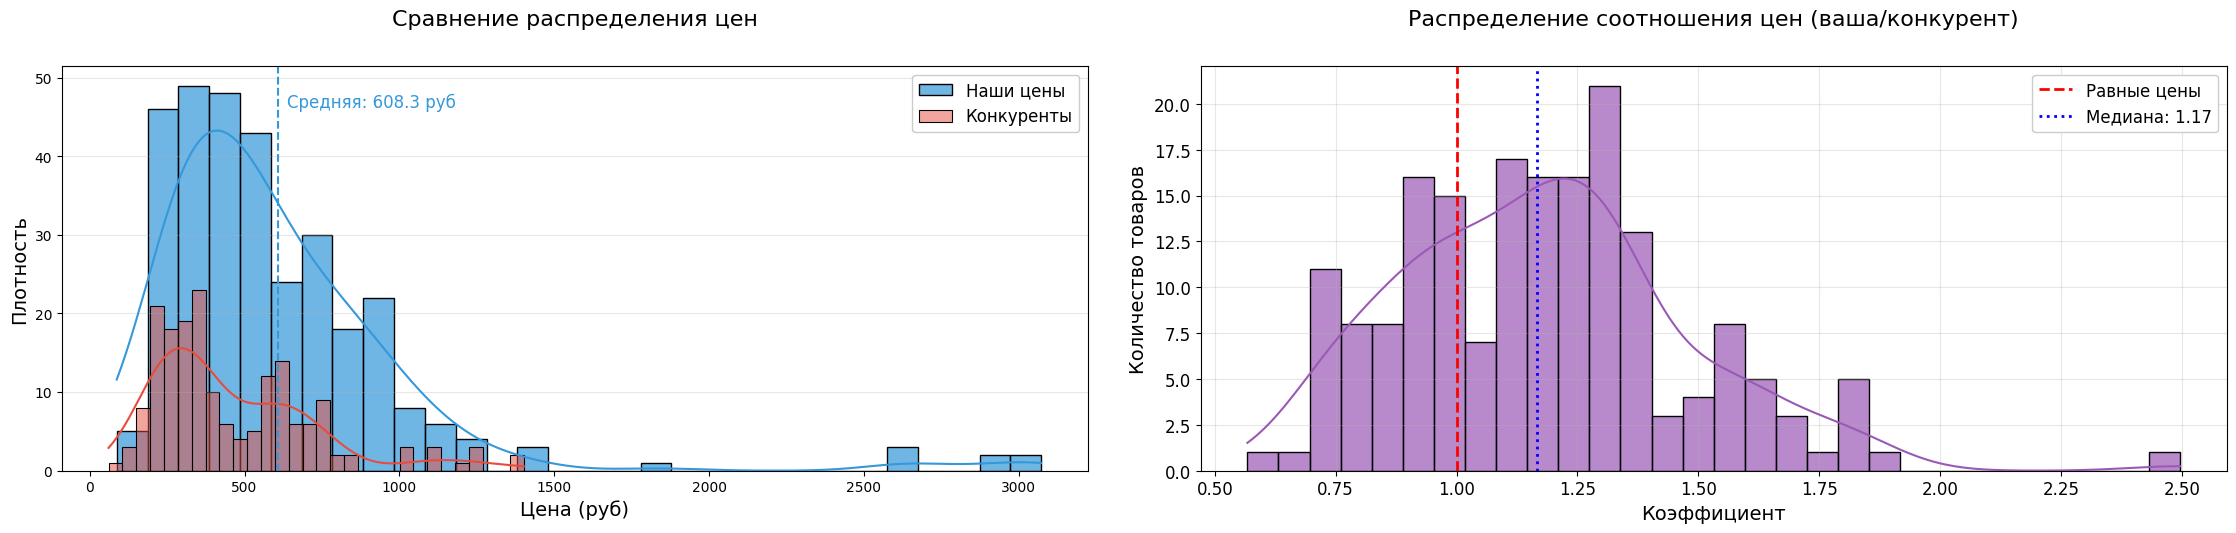

In [18]:
# Создаем фигуру с двумя горизонтальными подграфиками
plt.figure(figsize=(23, 6))

# Общие параметры оформления
title_params = {'fontsize': 16, 'pad': 15, 'y': 1.05}  # Единые параметры для заголовков
label_params = {'fontsize': 14}  # Параметры подписей осей
grid_params = {'alpha': 0.3}  # Параметры сетки

# Первый график - сравнение распределений цен
plt.subplot(1, 2, 1)
ax1 = sns.histplot(data=df, x='Маркетинговая цена', bins=30, 
                  color='#3498db', alpha=0.7, kde=True,
                  label='Наши цены')

sns.histplot(data=df.dropna(subset=['Мин. цена конкурентов']), 
            x='Мин. цена конкурентов', bins=30,
            color='#e74c3c', alpha=0.5, kde=True,
            label='Конкуренты')

# Оформление первого графика
plt.title('Сравнение распределения цен', **title_params)
plt.xlabel('Цена (руб)', **label_params)
plt.ylabel('Плотность', **label_params)
plt.legend(fontsize=12, framealpha=1)
plt.grid(axis='y', **grid_params)

# Аннотации для первого графика
mean_price = df['Маркетинговая цена'].mean()
plt.axvline(mean_price, color='#3498db', linestyle='--')
plt.text(mean_price*1.05, plt.ylim()[1]*0.9, 
        f'Средняя: {mean_price:.1f} руб', 
        color='#3498db', fontsize=12)

# Второй график - соотношение цен
plt.subplot(1, 2, 2)
df['Соотношение цен'] = df['Маркетинговая цена'] / df['Мин. цена конкурентов']
ax2 = sns.histplot(df['Соотношение цен'].dropna(), bins=30, 
                  color='#9b59b6', alpha=0.7, kde=True)

# Оформление второго графика (идентичное первому)
plt.title('Распределение соотношения цен (ваша/конкурент)', **title_params)
plt.xlabel('Коэффициент', **label_params)
plt.ylabel('Количество товаров', **label_params)

# Вертикальные линии и легенда
plt.axvline(1, color='red', linestyle='--', linewidth=2, label='Равные цены')
median_val = df['Соотношение цен'].median()
plt.axvline(median_val, color='blue', linestyle=':', linewidth=2, 
           label=f'Медиана: {median_val:.2f}')

plt.legend(fontsize=12, framealpha=1)
plt.grid(**grid_params)

# Общие настройки для обоих графиков
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Автоматическая регулировка расстояний между элементами
plt.tight_layout(pad=3.0)
plt.show()

| Левый график: | Правый график: |
|---------------|----------------|
| <ul><li>Синий график показывает распределение ваших цен, красный - цен конкурентов</li><li>Сравнение средних и медианных значений показывает позиционирование на рынке</li><li>Разница в форме распределений указывает на различия в ассортименте или стратегии</li></ul> | <ul><li>Медиана >1 означает, что большинство ваших товаров дороже конкурентов</li><li>Широкий разброс → неконсистентная ценовая политика</li><li>Левый хвост (<0.7) → возможные точки роста цены</li><li>Правый хвост (>2) → критические позиции для пересмотра</li></ul> |

In [19]:
# Рассчитываем статистики
price_comparison = df.groupby('Категория').agg({
    'Маркетинговая цена': 'median',
    'Мин. цена конкурентов': 'median'
}).dropna()

# Добавляем расчет отклонений
price_comparison['Отклонение'] = price_comparison['Маркетинговая цена'] - price_comparison['Мин. цена конкурентов']
price_comparison['Отклонение %'] = (price_comparison['Отклонение'] / price_comparison['Мин. цена конкурентов']) * 100

# Сортируем по отклонению
price_comparison = price_comparison.sort_values('Отклонение', ascending=False)

# Форматируем числа
styled_table = (price_comparison
                .style
                .format({
                    'Маркетинговая цена': '{:,.0f} руб',
                    'Мин. цена конкурентов': '{:,.0f} руб',
                    'Отклонение': '{:+,.0f} руб',
                    'Отклонение %': '{:+.1f}%'
                })
                .background_gradient(cmap='RdYlGn', subset=['Отклонение %'])
                .set_caption('Сравнение цен по категориям'))

## Основные выводы по структуре цен

        ** Доминирование премиального сегмента  --  61.3% товаров (84+27) дороже конкурентов более чем на 10%

        ** Упущенные возможности  --  16.6% товаров существенно дешевле (возможны потери маржи)

        ** Зона риска  --  14.9% товаров с ценой >50% выше рынка могут терять продажи

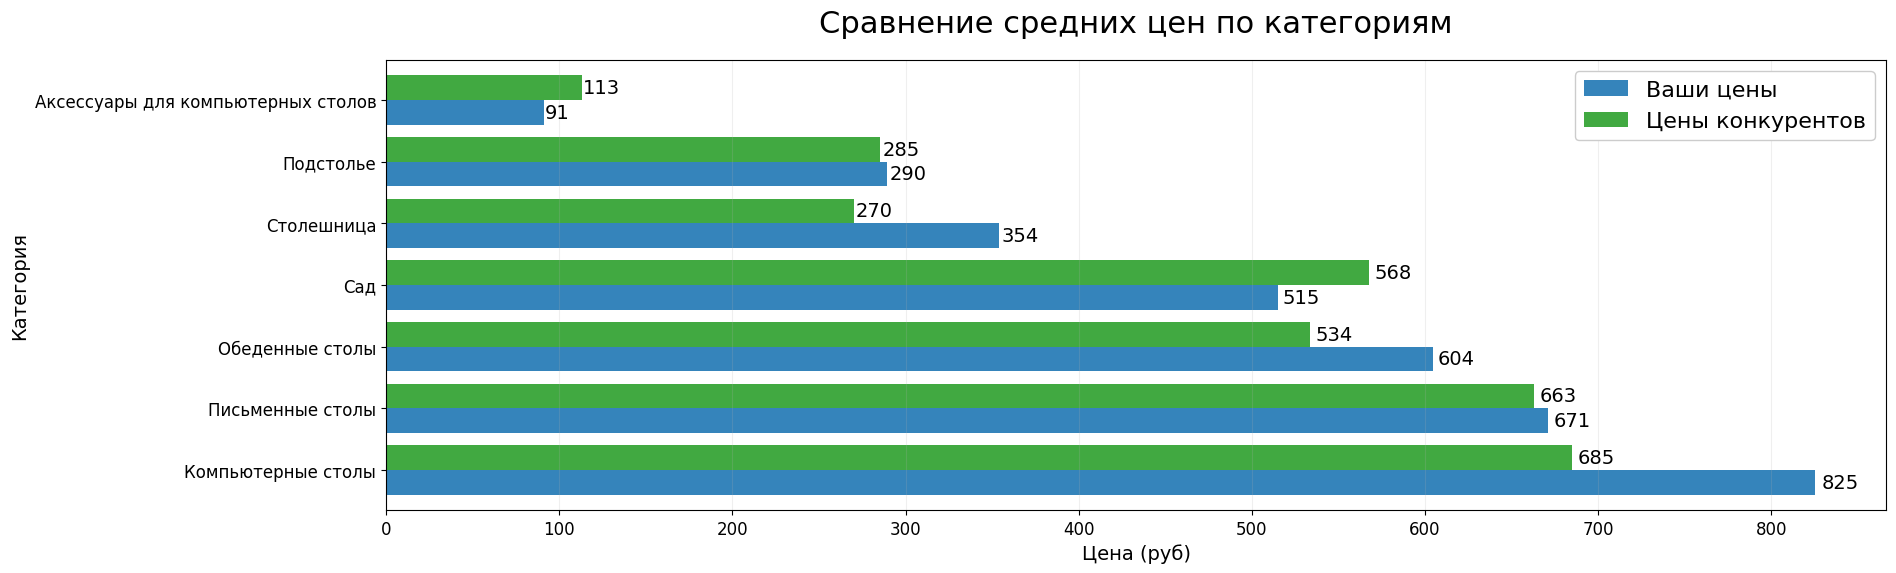

In [20]:
fig, ax = plt.subplots(figsize=(20, 6)) 

# Подготовка данных
category_stats = df.groupby('Категория')[['Маркетинговая цена', 'Мин. цена конкурентов']].median()
category_stats = category_stats.sort_values('Маркетинговая цена', ascending=False)

# Рисуем горизонтальные столбцы
category_stats.plot(
    kind='barh',
    ax=ax,  # Явно указываем ось
    width=0.8,
    color=['#1f77b4', '#2ca02c'],  # Оптимальные цвета
    alpha=0.9
)

# Настройки оформления
ax.set_title('Сравнение средних цен по категориям', fontsize=22, pad=20)
ax.set_xlabel('Цена (руб)', fontsize=14)
ax.set_ylabel('Категория', fontsize=14)
ax.grid(True, axis='x', alpha=0.2)

# Увеличиваем шрифты
ax.tick_params(axis='both', labelsize=12)

# Легенда
ax.legend(
    ['Ваши цены', 'Цены конкурентов'],
    fontsize=16,
    loc='upper right',
    framealpha=1
)

# Подписи значений (только для широких столбцов)
for p in ax.patches:
    width = p.get_width()
    if width > category_stats.values.max() * 0.05:  # Подписываем только значимые
        ax.annotate(
            f'{width:.0f}',
            (width * 1.005, p.get_y() + p.get_height()/2),
            ha='left', va='center',
            fontsize=14,
            color='black'
        )

# Критически важная настройка!
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.9)
plt.show()

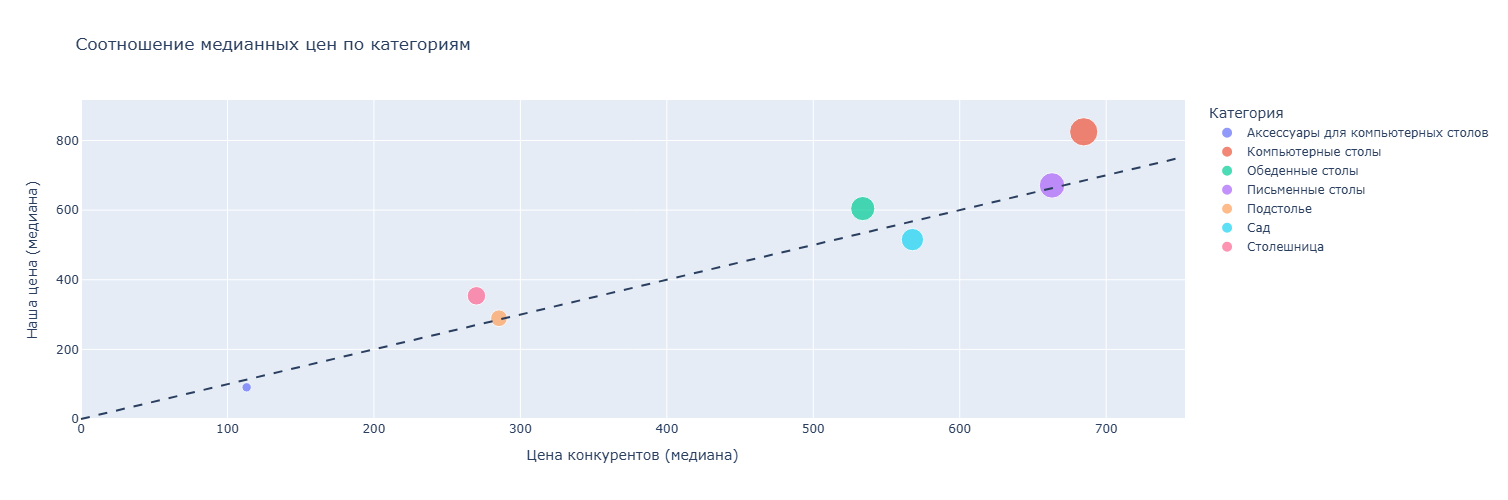

In [21]:
# Группируем данные
category_stats = df.groupby('Категория').agg({
    'Маркетинговая цена': 'median',
    'Мин. цена конкурентов': 'median'
}).reset_index().dropna()

# Создаем интерактивный график
fig = px.scatter(
    category_stats,
    x='Мин. цена конкурентов',
    y='Маркетинговая цена',
    size='Маркетинговая цена',
    color='Категория',
    hover_name='Категория',
    labels={'Мин. цена конкурентов': 'Цена конкурентов (медиана)',
            'Маркетинговая цена': 'Наша цена (медиана)'},
    title='Соотношение медианных цен по категориям'
)

# Добавляем линию равенства
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=0, y0=0,
    x1=category_stats['Мин. цена конкурентов'].max()*1.1,
    y1=category_stats['Мин. цена конкурентов'].max()*1.1
)

fig.update_layout(width=1000, height=500)
fig.show()

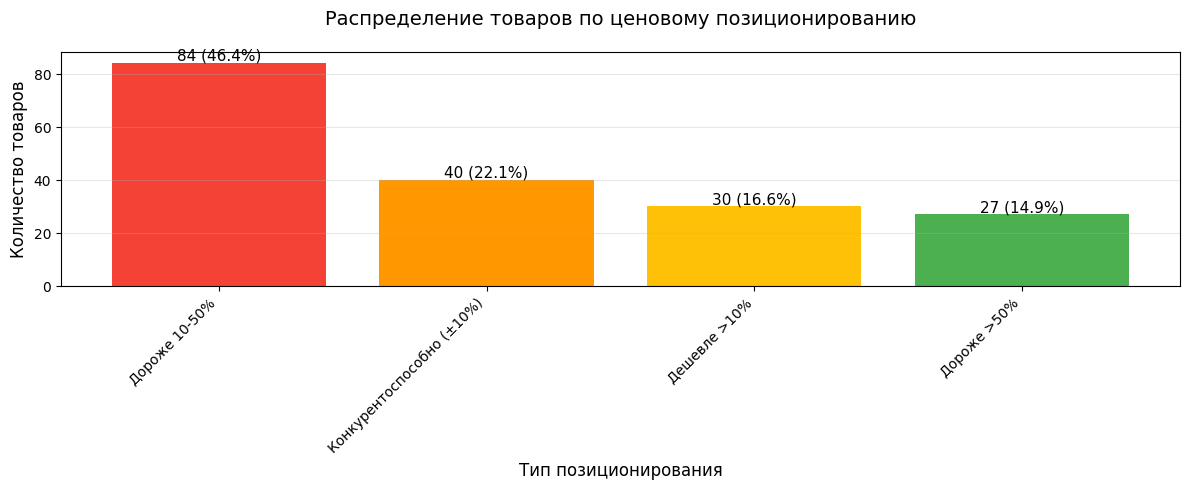

In [22]:
# Создаем данные для визуализации (на основе вашего распределения)
data = {
    'Позиционирование': ['Дешевле >10%', 'Конкурентоспособно (±10%)', 'Дороже 10-50%', 'Дороже >50%'],
    'Количество': [30, 40, 84, 27]
}

# Преобразуем в DataFrame для удобства
price_positioning = pd.DataFrame(data)
plt.figure(figsize=(12, 5))

# Сортируем данные
price_positioning = price_positioning.sort_values('Количество', ascending=False)

# Столбчатая диаграмма
bars = plt.bar(
    price_positioning['Позиционирование'],
    price_positioning['Количество'],
    color=['#F44336', '#FF9800', '#FFC107', '#4CAF50']
)

# Добавляем подписи
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height} ({height/sum(data["Количество"])*100:.1f}%)',
             ha='center', va='bottom', fontsize=11)

plt.title('Распределение товаров по ценовому позиционированию', fontsize=14, pad=20)
plt.xlabel('Тип позиционирования', fontsize=12)
plt.ylabel('Количество товаров', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Рекомендации по группам ценовых отклонений:


### для товаров "Дороже >50%" (27 шт):

        -- Проверить закупочные цены
        -- Верифицировать уникальность характеристик
        -- Поэтапное снижение до 1.3-1.5 от конкурентов
        -- Для уникальных товаров - усилить маркетинг

### для товаров "Дороже 10-50%" (84 шт):

    -> Премиум-позиционирование (для 10-30%)
    -> Постепенная оптимизация (для 30-50%)

        ** Поэтапное снижение цен на 10-15% каждые 2 недели до достижения коэффициента 1.2-1.3
        ** Акцентирование уникальности для оправдания цены

### для конкурентоспособных товаров (40 шт):
    
    ->>  Фиксация текущего ценового уровня
    ->>  Мониторинг реакции конкурентов
    
    Продвижение:

    ->>> Выделение как "Выбор по соотношению цена/качество"
    ->>> Размещение в рекомендательных блоках


### Для товаров "Дешевле >10%" (30 шт):

    ->>>> Постепенное повышение до 0.95-1.0 от конкурентов

        АНАЛИЗ ПРИЧИН:

        - Ошибки в закупках
        - Устаревшие цены
        - Стратегический демпинг

        
        Итоговый план действий:

    1) Корректировка цен для >50% группы
    2) Аудит себестоимости
    3) Запуск А/В тестов для 10-50% группы
    4) Анализ ценовых эластичностей
    5) Внедрение динамического ценообразования
    6) Настройка мониторинга конкурентов


## Статистика отклонений

### Выявление явных завышений цен (при условии проверки себестоимости и отсутствия демпинга со стороны конкурентов);

In [23]:
# Анализ переоцененных товаров
overpriced = df[df['Соотношение цен'] > 1.5]
if not overpriced.empty:
    print(f"\n\nТовары с завышенной ценой (>50% дороже конкурентов) - {len(overpriced)} шт:")
    print(overpriced[['Категория', 'Номенклатура', 'Маркетинговая цена', 'Мин. цена конкурентов', 'Соотношение цен']]
          .sort_values('Соотношение цен', ascending=False)
          .head(10)
          .to_string(index=False))




Товары с завышенной ценой (>50% дороже конкурентов) - 27 шт:
      Категория                  Номенклатура  Маркетинговая цена  Мин. цена конкурентов  Соотношение цен
     Столешница   прямоугольная 1400х700 (36)              406.35                 162.78         2.496314
     Столешница С закруг.углами 1400х800 (36)              437.07                 232.20         1.882300
     Столешница   прямоугольная 1400х700 (36)              385.50                 210.48         1.831528
     Столешница С закруг.углами 1400х800 (36)              437.07                 239.49         1.825003
     Столешница   прямоугольная 1300х800 (36)              397.47                 219.75         1.808737
     Столешница   прямоугольная 1200х700 (36)              344.52                 191.46         1.799436
     Столешница С закруг.углами 1400х800 (36)              437.07                 243.75         1.793108
     Столешница      геймерская 1600х800 (36)              494.79                 285.03 

### Выявление позиций с заниженной ценой (по сравнению с минимальной ценой конкурентов)

In [24]:
# Анализ недооцененных товаров
underpriced = df[df['Соотношение цен'] < 0.9]
if not underpriced.empty:
    print(f"\nТовары с заниженной ценой (>10% дешевле конкурентов) - {len(underpriced)} шт:")
    print(underpriced[['Категория', 'Номенклатура', 'Маркетинговая цена', 'Мин. цена конкурентов', 'Соотношение цен']]
          .sort_values('Соотношение цен')
          .head(10)
          .to_string(index=False))



Товары с заниженной ценой (>10% дешевле конкурентов) - 30 шт:
      Категория            Номенклатура  Маркетинговая цена  Мин. цена конкурентов  Соотношение цен
Обеденные столы          1600х1000 (36)              425.91                 750.69         0.567358
Обеденные столы          1600х1000 (36)              485.58                 741.18         0.655144
     Столешница Овальная 1600х1000 (36)              243.33                 341.79         0.711928
     Столешница Овальная 1800х1000 (36)              272.43                 382.59         0.712068
     Столешница Овальная 1800х1000 (36)              272.43                 382.59         0.712068
     Столешница Овальная 1600х1000 (36)              243.33                 337.47         0.721042
     Столешница Овальная 1600х1000 (36)              247.65                 341.79         0.724568
            Сад    Керамогранит 600х600              263.76                 361.53         0.729566
            Сад    Керамогранит 600х6

### Выявление уникальных товаров

In [25]:
# Анализ товаров без конкурентов
no_competition = df[df['Мин. цена конкурентов'].isna()]
print(f"\nУникальные товары без конкурентов - {len(no_competition)} шт:")
print("Распределение по категориям:")
print(no_competition['Категория'].value_counts().head(10))


Уникальные товары без конкурентов - 133 шт:
Распределение по категориям:
Категория
Компьютерные столы                    47
Столешница                            40
Обеденные столы                       23
Подстолье                             11
Сад                                   10
Письменные столы                       1
Аксессуары для компьютерных столов     1
Name: count, dtype: int64


In [26]:
import pandas as pd
from IPython.display import display

# Данные
category_strategy = pd.DataFrame({
    'Категория': ['Компьютерные столы', 'Столешница', 'Обеденные столы', 'Подстолье', 'Сад'],
    'Уникальные товары': [47, 40, 23, 11, 10],
    'Рекомендуемая наценка (%)': [25, 20, 15, 10, 15],
    'Приоритет': [1, 2, 3, 4, 5]
})

# Стилизация таблицы
def style_table(df):
    # Цвета фона для приоритетов (светлые тона)
    priority_bg_colors = {
        1: '#FFCDD2',  # Светло-красный
        2: '#FFE0B2',  # Светло-оранжевый
        3: '#FFF9C4',  # Светло-желтый
        4: '#C8E6C9',  # Светло-зеленый
        5: '#B3E5FC'   # Светло-синий
    }
    
    # Основные стили
    styles = [
        # Заголовок таблицы
        {'selector': 'caption',
         'props': [('font-size', '18px'),
                   ('font-weight', 'bold'),
                   ('color', 'black'),
                   ('margin-bottom', '15px')]},
        
        # Заголовки столбцов
        {'selector': 'th',
         'props': [('background-color', '#424242'),
                  ('color', 'white'),
                  ('font-weight', 'bold'),
                  ('font-size', '14px'),
                  ('text-align', 'center'),
                  ('padding', '10px'),
                  ('border', '1px solid white')]},
        
        # Основные ячейки
        {'selector': 'td',
         'props': [('font-size', '13px'),
                  ('font-weight', 'bold'),
                  ('text-align', 'center'),
                  ('padding', '10px'),
                  ('border', '1px solid #e0e0e0'),
                  ('color', 'black')]},  # Черный шрифт везде
        
        # Чередование строк для лучшей читаемости
        {'selector': 'tr:nth-of-type(even)',
         'props': [('background-color', '#f5f5f5')]},  # Светло-серый
        
        {'selector': 'tr:nth-of-type(odd)',
         'props': [('background-color', 'white')]},  # Белый
        
        # Ячейки с категориями - особое выделение
        {'selector': 'td:nth-child(1)',
         'props': [('font-weight', 'bold'),
                  ('color', '#0d47a1'),  # Темно-синий
                  ('text-align', 'left'),
                  ('padding-left', '15px')]}
    ]
    
    # Применяем стили
    styled = (df.style
              .set_table_styles(styles)
              .set_caption('СТРАТЕГИЯ ДЛЯ УНИКАЛЬНЫХ ТОВАРОВ')
              .background_gradient(subset=['Уникальные товары'], 
                                 cmap='Blues',
                                 text_color_threshold=0.5)  # Автоподбор цвета текста
              .apply(lambda x: [f'background-color: {priority_bg_colors[v]}' 
                               for v in x], 
                    subset=['Приоритет'])
              .applymap(lambda x: 'color: #d32f2f' if x < 15 else 'color: #388e3c', 
                       subset=['Рекомендуемая наценка (%)'])
              .format({'Рекомендуемая наценка (%)': '{:.0f}%'})
              .set_properties(**{'border-collapse': 'collapse'})
              .hide(axis='index'))
    
    return styled

# Отображаем таблицу
display(style_table(category_strategy))

C:\Users\Professional\AppData\Local\Temp\ipykernel_8116\3736465624.py:76: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



Категория,Уникальные товары,Рекомендуемая наценка (%),Приоритет
Компьютерные столы,47,25%,1
Столешница,40,20%,2
Обеденные столы,23,15%,3
Подстолье,11,10%,4
Сад,10,15%,5


## Рекомендации по уникальным товарам:
    
    1) ПОЗИЦИОНИРОВАНИЕ:

        ->> "Эргономичные решения для дома и офиса"
        ->> Упор на здоровье спины и увеличение продуктивности

    2) ДОПОЛНИТЕЛЬНЫЙ СЕРВИС:

        ->>> Бесплатная сборка (+15% к цене в себестоимости)
        ->>> Гарантия 5 лет

    3) МАРКЕТИНГ:

        ->>>> Партнерство с IT-компаниями для корпоративных заказов
        ->>>> Реклама в тематических пабликах (Dzen, VC.ru)